In [1]:
import sys
sys.path.insert(0, '../')
from util import util
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt

from scipy.optimize import minimize
import pymc3 as pm
import pandas as pd
import seaborn as sns
import pymc3.sampling as sampling

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Portfolio optimisation

Demiguel Nogalwes 2009 ran a model as followed:

We will assume the true asset-return distribution is given as $$G = 99\% \times \mathcal{N}(\mu,\Sigma) + 1\% \times D $$
where $D = \mathcal{N}(\mu_d,\Sigma_d)$ where $\Sigma_d=\Sigma$

Lim et al used the follow model:
$$ \mathbf{X} \sim \mathcal{N}(\mathbf{\mu},\mathbf{\Sigma})$$

</p>Given $N$ risky assets the mean variance portfolio is the solution to the problem 
$$\min_w \mathbf{w}^T\hat{\Sigma}\mathbf{w} - \frac{1}{\gamma}\hat{\mathbf{\mu}}^T\mathbf{w}$$ 
$$s.t. \mathbf{w}^T\mathbf{e} = 1 $$</p>

<p> We also seek to find the minimum-variance porfolio 
    $$\min_w \mathbf{w}^T\hat{\Sigma}\mathbf{w}$$
    $$s.t. \mathbf{w}^T\mathbf{e} = 1 $$</p>

In [2]:
mu = np.array([26.11 , 25.21 , 28.90 , 28.68 , 24.18])*10e-4
covar = np.array([[3.715 , 3.730 , 4.420 , 3.606 , 3.673],
                 [3.730 , 3.908 , 4.943 , 3.732 , 3.916],
                [4.420 , 4.943 , 8.885 , 4.378 , 5.010],
                  [3.606 , 3.732 , 4.378 , 3.930 , 3.789],
                  [3.673 , 3.916 , 5.010 , 3.789 , 4.027]])*10e-4
model = st.multivariate_normal(mean=mu,cov=covar)

In [3]:
def mean_variance(weights,mean,cov,gamma,average=False):
    var = np.dot(np.dot(weights,cov_est),weights)
    mean = 1.0/gamma*np.dot(mean,weights)
    if average:
        return np.mean(var-mean,axis=0)
    else: 
        return var-mean

In [4]:
def sum_weights(weights):
    return np.sum(weights)-1

In [32]:
init_weights = np.ones((5))/5
gamma = [0.1,1.0,5.0,10]
N = [50,100,200]
constraints = [{'type':'eq','fun':sum_weights}]
n_iter = 1000
df = pd.DataFrame(columns=['w_star','method','gamma','N'])

In [33]:
for j in range(len(gamma)):
    for l in range(n_iter):
        for i in range(len(N)):
            samples = model.rvs(N[i])
            cov_est = np.cov(samples.T)
            mean_est = np.mean(samples,axis=0)
            res = minimize(mean_variance,init_weights,args=(mean_est,cov_est,gamma[j],
                                                            False),
                          constraints=constraints,
                          bounds=[(0,None)]*5)
            results = {'w_star': res.x,'method':'SAA','gamma':gamma[j],'N':N[i]}
            df = df.append(results,ignore_index=True)
            
            
    res = minimize(mean_variance,init_weights,args=(mu,covar,gamma[j]),
                          constraints=constraints,
                          bounds=[(0,None)]*5)
    results = {'w_star': res.x,'method':'True','gamma':gamma[j],'N':N[i]}
    df = df.append(results,ignore_index=True)

In [34]:
df['expected_return'] = df['w_star'].apply(lambda x:np.dot(mu,x))

In [35]:
df.to_csv("portfolio_opt.csv")

In [36]:
df = pd.read_csv("portfolio_opt.csv",index_col=0)

In [37]:
df[df['method']=='True']

,w_star,method,gamma,N,expected_return
3000,[3.97205465e-16 0.00000000e+00 2.40396728e-01 ...,True,0.1,200,0.028733
6001,[1.94289029e-16 0.00000000e+00 0.00000000e+00 ...,True,1.0,200,0.028680
9002,[3.60456875e-01 9.48441679e-02 4.33680869e-17 ...,True,5.0,200,0.027425
12003,[2.82611182e-01 2.26234045e-01 5.55111512e-17 ...,True,10.0,200,0.026257


In [38]:
gamma_df = df[df['gamma']==1]

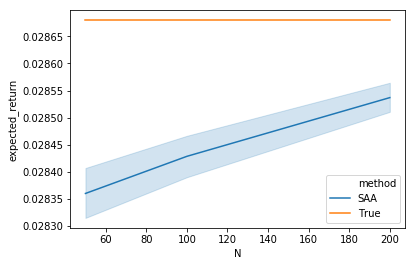

In [39]:
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['expected_return'], 
                  hue=gamma_df['method'])
plt.plot(N,[gamma_df[gamma_df['method']=='True']['expected_return'].iloc[0]]*3)

## Using Bayesian inference

We use a normal-inversewishart prior on the mean and covariance of the multivariate gaussian.

$$p(\mu|\Sigma)\sim \mathcal{N}(27*10^{-4},10^{-4}\Sigma)$$
$$p(\Sigma)\sim \mathcal{W}^{-1}(\mathbf{I},1)$$


In [40]:
mu0 = np.array([27e-3]*5)
m =1/10e-4
Psi = np.eye(5)
nu0 = 5

In [41]:
n_iter=1000

In [42]:
df = pd.read_csv("portfolio_opt.csv",index_col=0)

In [44]:
new_samples = []
for j in range(len(gamma)):
    for l in range(n_iter):
        for i in range(len(N)):
            n = N[i]
            samples = model.rvs(n)
            sample_mean = np.mean(samples,axis=0)
            sample_cov = np.cov(samples.T)
            posterior_sigma_scale = Psi+n*sample_cov+m*n/(n+m)*np.dot((sample_mean-mu0).T,
                                                                  sample_mean-mu0)
            posterior_sigma_nu = n+nu0
            cov_array = []
            mean_array = []
            for k in range(2000):

                cov_array.append(st.invwishart.rvs(
                                scale=posterior_sigma_scale,
                                df=posterior_sigma_nu))
                posterior_mean_mu = (n*sample_mean+m*mu0)/(m+n)
                #mean_wishart = posterior_sigma_scale/(posterior_sigma_nu-sample_mean.shape[0]-1)
                posterior_mean_sigma = 1/(m+n)*cov_array[k]
                mean_array.append(st.multivariate_normal.rvs(posterior_mean_mu,
                                                            posterior_mean_sigma))
            res = minimize(mean_variance,
                            init_weights,
                            args=(mean_array,
                                  cov_array,
                                    gamma[j],
                                     True),
                          constraints=constraints,
                          bounds=[(0,None)]*5)
            results = {'w_star': res.x,'method':'Bayesian','gamma':gamma[j],'N':N[i]}
            df = df.append(results,ignore_index=True)
            

In [53]:
df['expected_return'] = df[df['method']=='Bayesian']['w_star'].apply(lambda x:np.dot(
                                            mu,x))

In [55]:
df.to_csv("portfolio_opt.csv")

In [48]:
gamma_df = df[df['gamma']==1]

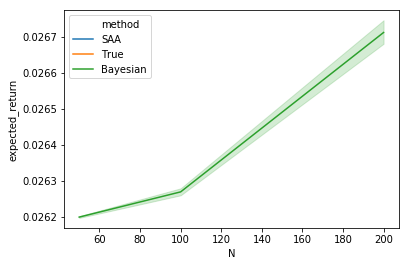

In [49]:
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['expected_return'], 
                  hue=gamma_df['method'])
plt.plot(N,[gamma_df[gamma_df['method']=='True']['expected_return'].iloc[0]]*3)

In [ ]:
np.dot(mu,df[df['method']=='Bayesian'].iloc[0]['w_star'])

In [ ]:
df[df['method']=='Bayesian']['w_star']